In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
fileName = "PSP_Jan_Feb_2019.xlsx"
raw_data = pd.read_excel(fileName)
raw_data = raw_data.drop('Unnamed: 0',axis = 1)

In [3]:
raw_data.head(20)

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master
7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master
8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa
9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa


In [11]:
NA = raw_data.isna().sum().sum()
NULL = raw_data.isnull().sum().sum()
INF = raw_data.isin([np.inf, -np.inf]).sum().sum()

print(f'Total NA: {NA}+\n\n')
print(f'Total NULL: {NULL}+\n\n')
print(f'Total INF: {INF}+\n\n')

Total NA: 0+


Total NULL: 0+


Total INF: 0+




In [12]:
raw_data['tmsp'] = pd.to_datetime(raw_data['tmsp'])
raw_data['hour'] = raw_data['tmsp'].dt.hour
raw_data['day_of_week'] = raw_data['tmsp'].dt.day_of_week
raw_data['month'] = raw_data['tmsp'].dt.month
raw_data['minute'] = raw_data['tmsp'].dt.minute
raw_data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,hour,day_of_week,month,minute,fee,attempt_group
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,1,1,1,1.0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,1,1,1,3.0,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0,1,1,2,1.0,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0,1,1,3,3.0,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0,1,1,4,0.5,3


In [29]:
fee_structure = {
    'Moneycard': {1: 5, 0: 2},
    'Goldcard': {1: 10, 0: 5},
    'UK_Card': {1: 3, 0: 1},
    'Simplecard': {1: 1, 0: 0.5}
}
raw_data['fee'] = raw_data.apply(lambda x: fee_structure[x['PSP']][x['success']], axis=1)
raw_data.head(25)

,tmsp,country,amount,success,PSP,3D_secured,card,hour,day_of_week,month,minute,fee,attempt_group
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0,1,1,1,1.0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0,1,1,1,3.0,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0,1,1,2,1.0,2
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0,1,1,3,3.0,2
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0,1,1,4,0.5,3
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,0,1,1,6,1.0,4
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,0,1,1,7,0.5,4
7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master,0,1,1,8,3.0,5
8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa,0,1,1,9,0.5,6
9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa,0,1,1,10,0.5,6


In [31]:
raw_data['attempt_group'] = (raw_data['tmsp'].diff() > pd.Timedelta(minutes=1)) | (raw_data['country'].shift() != raw_data['country']) | (raw_data['amount'].shift() != raw_data['amount'])

raw_data['attempt_group'] = raw_data['attempt_group'].cumsum()

data = raw_data.groupby('attempt_group').agg({
    'tmsp': 'min',              # The earliest timestamp in the group
    'attempt_group': 'count',   # Number of transactions in the group
    'country': 'first',         # country must match within the group
    'amount': 'first',          # amount must match within the group
    'success': 'max',           # If any transaction within the group is successful, mark the group as successful
    'PSP': 'last',              # The last PSP used in the group
    '3D_secured': 'max',        # If any transaction within the group is 3D secured, mark the group as 3D secured
    'card': 'first',            # Use the first card used in the group
    'fee': 'sum'                # Sum of all fees within the group
}).reset_index(drop=True)

data.rename(columns={'attempt_group': 'attempts'}, inplace=True)

print(f"Success rate of unique transactions: {data['success'].mean():.1%}")

data.head(20)


Success rate of unique transactions: 37.4%


,tmsp,attempts,country,amount,success,PSP,3D_secured,card,fee
0,2019-01-01 00:01:11,2,Germany,89,1,UK_Card,0,Visa,4.0
1,2019-01-01 00:02:49,2,Germany,238,1,UK_Card,1,Diners,4.0
2,2019-01-01 00:04:33,1,Austria,124,0,Simplecard,0,Diners,0.5
3,2019-01-01 00:06:41,2,Switzerland,282,0,Simplecard,0,Master,1.5
4,2019-01-01 00:08:46,1,Germany,117,1,UK_Card,0,Master,3.0
5,2019-01-01 00:09:56,2,Switzerland,174,0,Simplecard,0,Visa,1.0
6,2019-01-01 00:12:15,5,Austria,232,1,UK_Card,1,Diners,6.5
7,2019-01-01 00:15:45,1,Germany,268,0,Simplecard,0,Master,0.5
8,2019-01-01 00:18:18,3,Switzerland,89,0,Moneycard,0,Master,3.5
9,2019-01-01 00:20:53,3,Germany,205,1,Moneycard,0,Master,7.0


In [23]:
std = np.std(data['amount'])
mean = np.mean(data['amount'])

c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

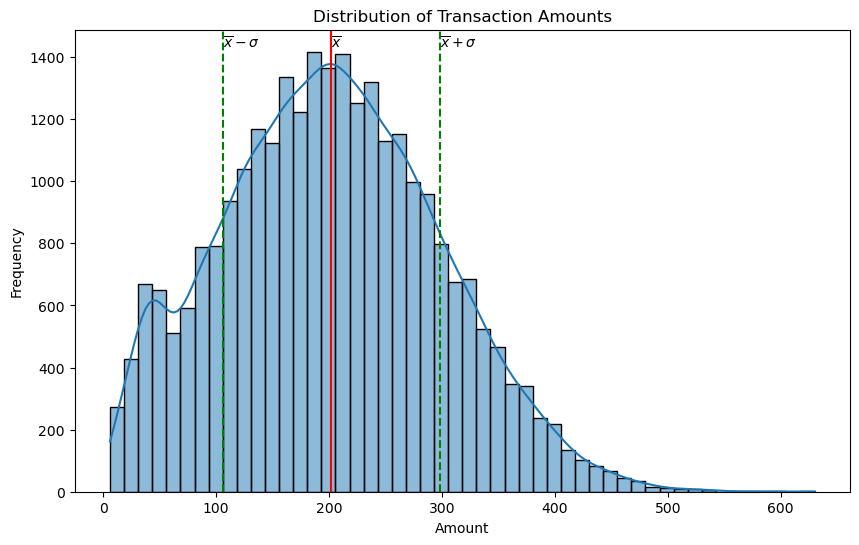

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data['amount'], bins=50, kde=True)
plt.axvline(x=mean, color='red', linestyle='-')
plt.axvline(x=mean+std, color='green', linestyle='--')
plt.axvline(x=mean-std, color='green', linestyle='--')
plt.text(mean, 1430, r'$\overline{x}$')
plt.text(mean+std, 1430, r'$\overline{x}+\sigma$')
plt.text(mean-std, 1430, r'$\overline{x}-\sigma$')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')

(array([0, 1, 2]),
 [Text(0, 0, 'Austria'), Text(1, 0, 'Germany'), Text(2, 0, 'Switzerland')])

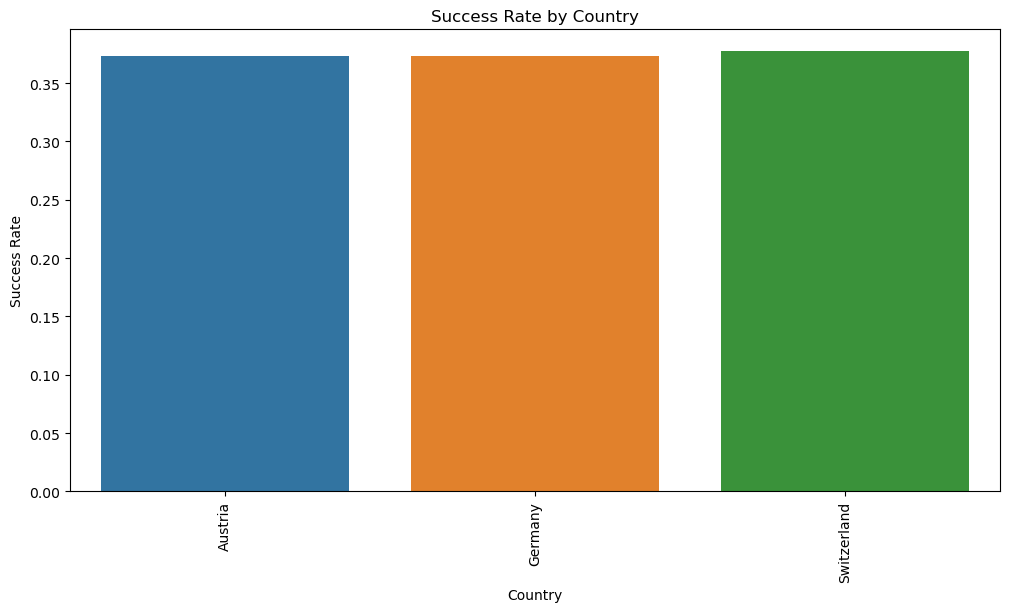

In [32]:
plt.figure(figsize=(12, 6))
success_by_country = data.groupby('country')['success'].mean().sort_values()
sns.barplot(x=success_by_country.index, y=success_by_country.values)
plt.title('Success Rate by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)

c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


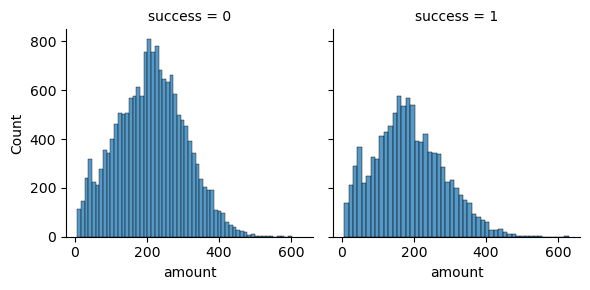

In [34]:
g = sns.FacetGrid(data, col="success")
g.map(sns.histplot, "amount")

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Simplecard'),
  Text(1, 0, 'Moneycard'),
  Text(2, 0, 'UK_Card'),
  Text(3, 0, 'Goldcard')])

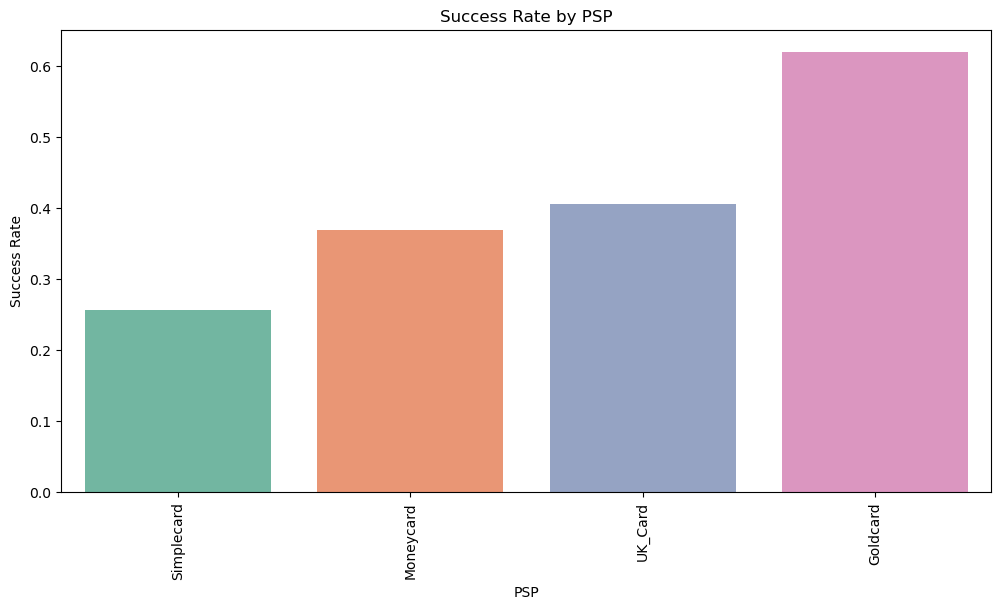

In [35]:
plt.figure(figsize=(12, 6))
success_by_psp = data.groupby('PSP')['success'].mean().sort_values()
sns.barplot(x=success_by_psp.index, y=success_by_psp.values, palette=sns.color_palette('Set2'))
plt.title('Success Rate by PSP')
plt.xlabel('PSP')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)

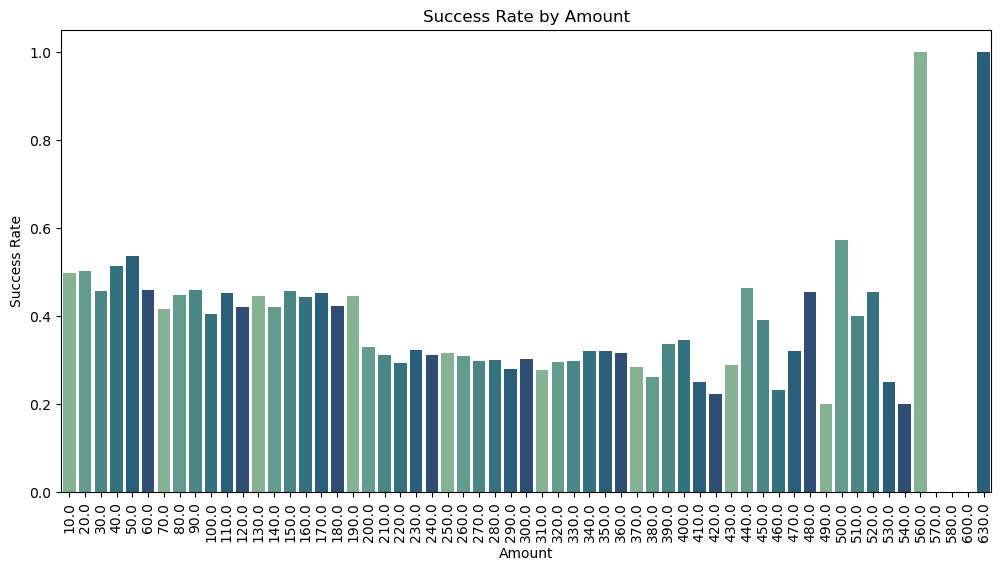

In [36]:
data['amount_bins'] = round(data['amount']/10)*10
plt.figure(figsize=(12, 6))
success_by_amount = data.groupby('amount_bins')['success'].mean().sort_values()
sns.barplot(x=success_by_amount.index, y=success_by_amount.values, palette=sns.color_palette('crest'))
plt.title('Success Rate by Amount')
plt.xlabel('Amount')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)
data = data.drop('amount_bins',axis = 1)

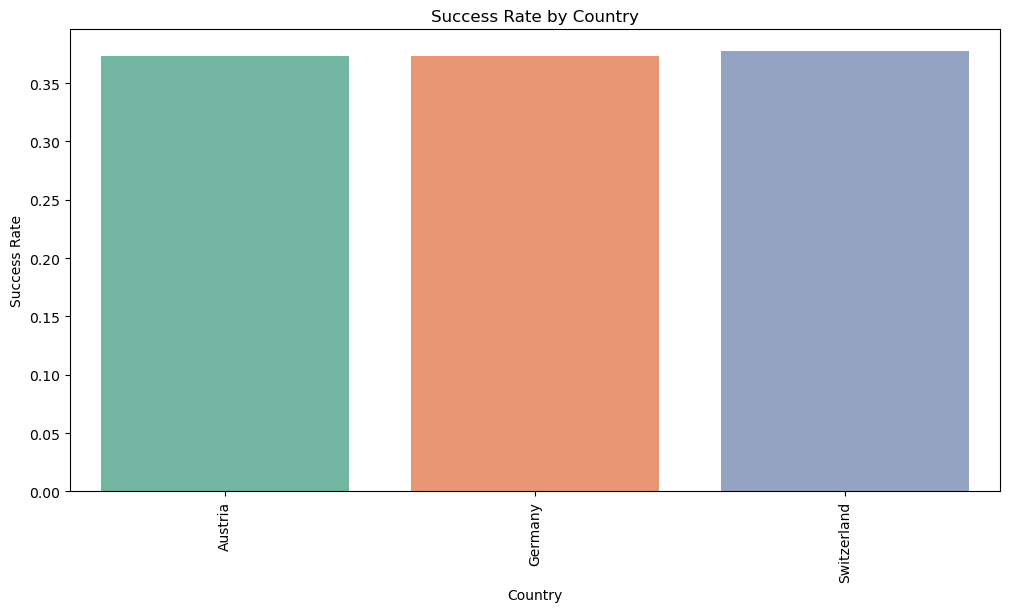

In [37]:
plt.figure(figsize=(12, 6))
success_by_country = data.groupby('country')['success'].mean().sort_values()
sns.barplot(x=success_by_country.index, y=success_by_country.values, palette=sns.color_palette('Set2'))
plt.title('Success Rate by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)
plt.show()

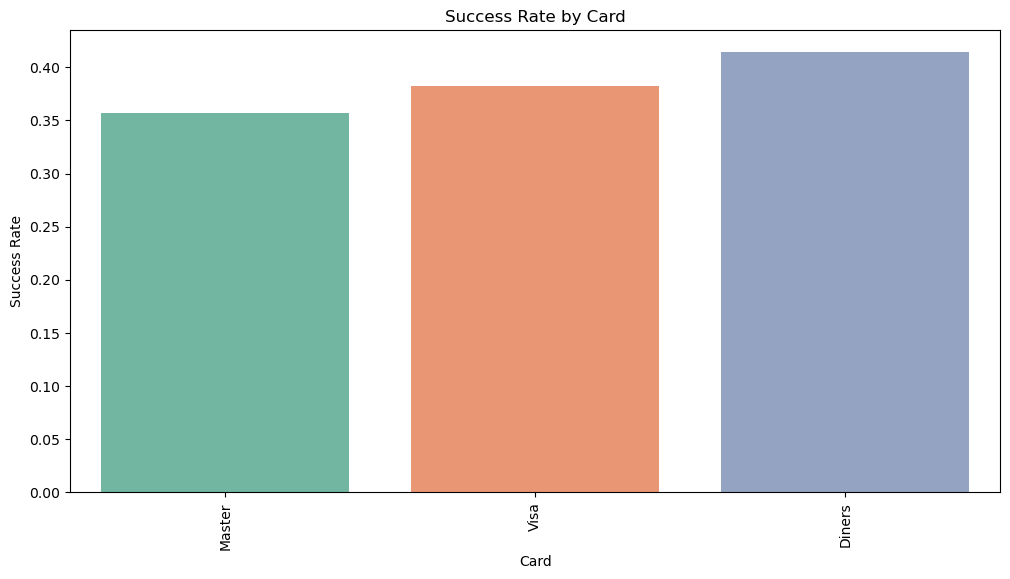

In [39]:
plt.figure(figsize=(12, 6))
success_by_card = data.groupby('card')['success'].mean().sort_values()
sns.barplot(x=success_by_card.index, y=success_by_card.values,palette=sns.color_palette('Set2'))
plt.title('Success Rate by Card')
plt.xlabel('Card')
plt.ylabel('Success Rate')
plt.xticks(rotation=90)
plt.show()

c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


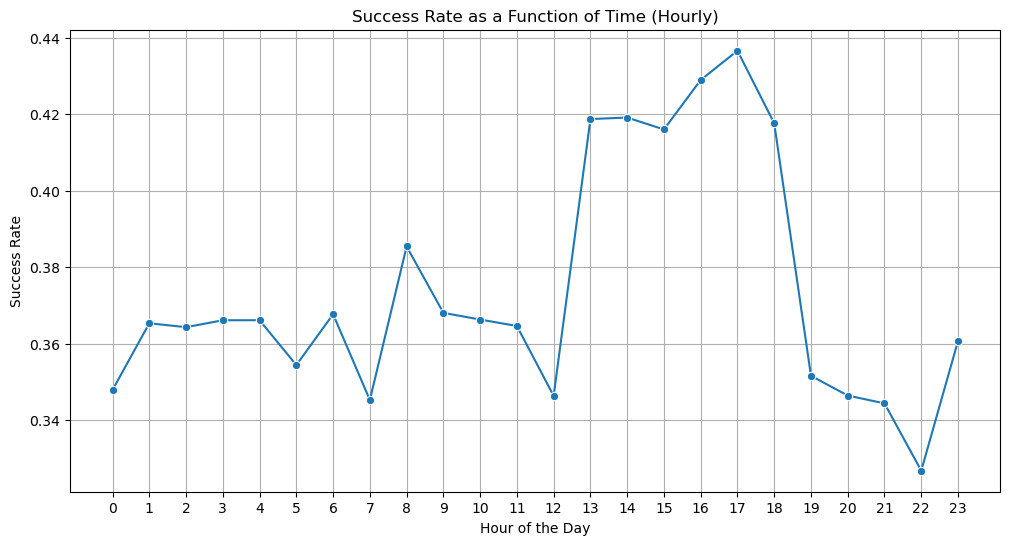

In [40]:
data['tmsp'] = pd.to_datetime(data['tmsp'])
data['hour'] = data['tmsp'].dt.hour
data['day_of_week'] = data['tmsp'].dt.day_of_week
data['month'] = data['tmsp'].dt.month

success_rate_by_hour = data.groupby('hour')['success'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=success_rate_by_hour.index, y=success_rate_by_hour.values, marker='o')
plt.title('Success Rate as a Function of Time (Hourly)')
plt.xlabel('Hour of the Day')
plt.ylabel('Success Rate')
plt.xticks(range(24))
plt.grid(True)

c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Phil\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


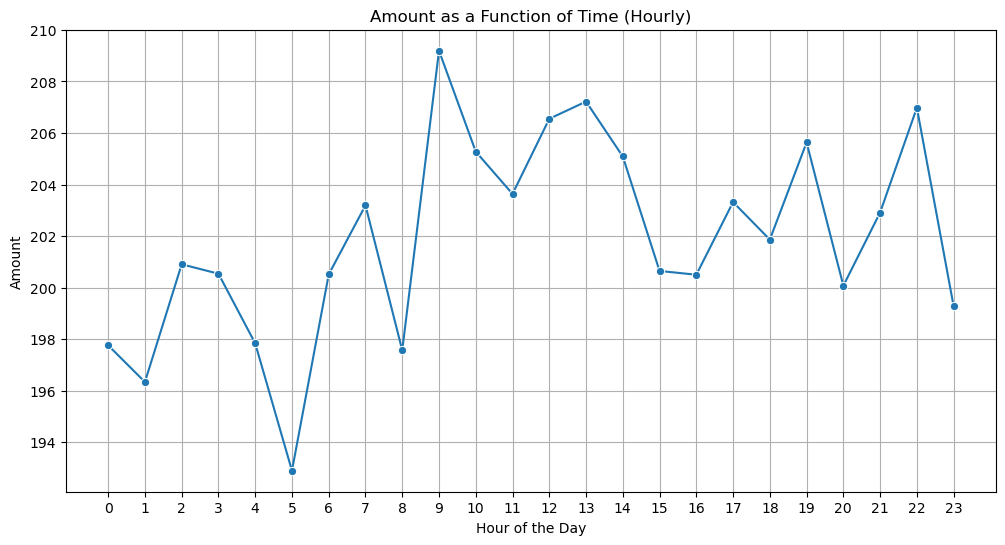

In [41]:
amount_by_hour = data.groupby('hour')['amount'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=amount_by_hour.index, y=amount_by_hour.values, marker='o')
plt.title('Amount as a Function of Time (Hourly)')
plt.xlabel('Hour of the Day')
plt.ylabel('Amount')
plt.xticks(range(24))
plt.grid(True)


Text(0, 0.5, 'Success Rate')

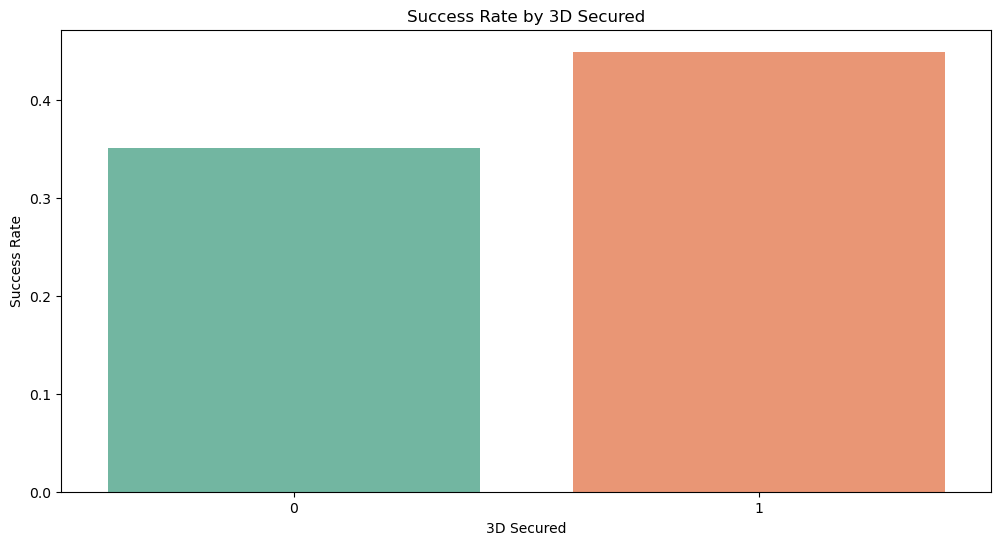

In [42]:
plt.figure(figsize=(12, 6))
success_by_3DSecure = data.groupby('3D_secured')['success'].mean().sort_values()
sns.barplot(x=success_by_3DSecure.index, y=success_by_3DSecure.values, palette=sns.color_palette('Set2'))
plt.title('Success Rate by 3D Secured')
plt.xlabel('3D Secured')
plt.ylabel('Success Rate')

In [43]:
scaler = MinMaxScaler()
 
data['amount_norm'] = scaler.fit_transform(data['amount'].to_numpy().reshape(-1,1))
data = data.drop(columns=['amount'])

,tmsp,attempts,country,success,PSP,3D_secured,card,fee,hour,day_of_week,month,amount_norm
0,2019-01-01 00:01:11,2,Germany,1,UK_Card,0,Visa,4.0,0,1,1,0.133013
1,2019-01-01 00:02:49,2,Germany,1,UK_Card,1,Diners,4.0,0,1,1,0.371795
2,2019-01-01 00:04:33,1,Austria,0,Simplecard,0,Diners,0.5,0,1,1,0.189103
3,2019-01-01 00:06:41,2,Switzerland,0,Simplecard,0,Master,1.5,0,1,1,0.442308
4,2019-01-01 00:08:46,1,Germany,1,UK_Card,0,Master,3.0,0,1,1,0.177885


In [ ]:
data = pd.get_dummies(data, columns=['country', 'card'], dtype=int)
data.head()

In [46]:
data.to_excel('C:\\Users\\Phil\\CaseStudy\\PSP_DATA_PREP.xlsx', index=False)